# 摘要

# 理论模型

玉米淀粉（Corn Starch）俗名六谷粉，白色微带淡黄色的粉末。玉米淀粉是将玉米经粗细研磨，分离出胚芽、纤维和蛋白质等副产品后得到的产品。一般来说，约 1.4 吨玉米（含 14% 水分）可以提取 1 吨玉米淀粉。

![玉米淀粉](.\images\玉米淀粉.PNG)

## 生产

* 清理：主要采用筛选、风选等方法。清理设备有振动筛、比重去石机、永磁滚筒和洗麦机等。
* 浸泡：普遍采用金属罐几只或者几十只用管道连接组合起来，用水泵是浸泡水在各罐之间循环流动，逆流浸泡。
* 玉米粗碎：粗碎可分成两次进行，首先把玉米破碎到 4~6 块，进行胚芽分离；在破碎到 10 块以上，使胚芽全部脱落，进行第二次胚芽分离。
* 胚芽分离：国内胚芽分离主要使用胚芽分离槽，分离效率一般不超过 85%。
* 玉米磨碎：经过分离胚芽后的玉米碎块和部分淀粉的混合物，必须进行磨碎，破坏玉米细胞，游离淀粉颗粒，使纤维和麸皮分开。
* 淀粉筛分：玉米碎块经过磨碎后，得到玉米糊，采用筛分的方法将淀粉和粗细渣分开。
* 蛋白质分离和淀粉清洗：蛋白质一般使用离心机分离。分离蛋白质后的粗制淀粉乳必须进行清洗，一般采用旋液分离器进行清洗，用 9~14 级旋液分离器处理。
* 离心分离和干燥：旋液分离器出来的淀粉乳含水 78%，必须经过脱水处理，再干燥后成为淀粉成品。

## 用途

* 淀粉糖：淀粉糖（含葡萄糖浆、麦芽糖浆、含 42% 果糖的果葡糖浆和含 55% 果糖的高果糖浆，以及医用结晶葡萄糖等）是淀粉深加工产量最大的一类产品。主要用作食品添加剂和工业原料，是葡萄糖、麦芽糖、高果糖浆、山梨醇、氨基酸等产品的上游原料。
* 氨基酸：以淀粉为原料生产的氨基酸有赖氨酸、味精（谷氨酸钠）、异亮氨酸、精氨酸、结氨酸等。生产的有机酸有柠檬酸、乳酸、苹果酸、衣康酸、草酸等。
* 变形淀粉：变性淀粉是利用物理、化学和酶等手段改变天然淀粉的性质，使其符合各行各业应用的需要。在纺织、造纸、食品、石油、医用、建筑、农业饲料、日用化工等行业有广泛应用。
* 医药：淀粉是抗生素工业最重要的原料，因为几乎所有抗生素都采用淀粉发酵法生产，如销量极大的青霉素、头孢菌素、四环素、土霉素、金霉素、链霉素与各种氨基糖苷类抗生素等，无一不是用淀粉为底物经工业微生物发酵、提取而成。另外，淀粉的另一重要用途是作为药物赋型剂，早期各国药厂生产的片剂绝大多数使用玉米淀粉为填充剂及粘合剂。
* 食品加工：淀粉作为原料可以直接用于粉丝、粉条、肉制品、冰激凌等食品生产。
* 啤酒：用淀粉生产的啤酒糖浆，可直接加到麦芽汁里，简化了生产工艺。

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from WindPy import w
import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

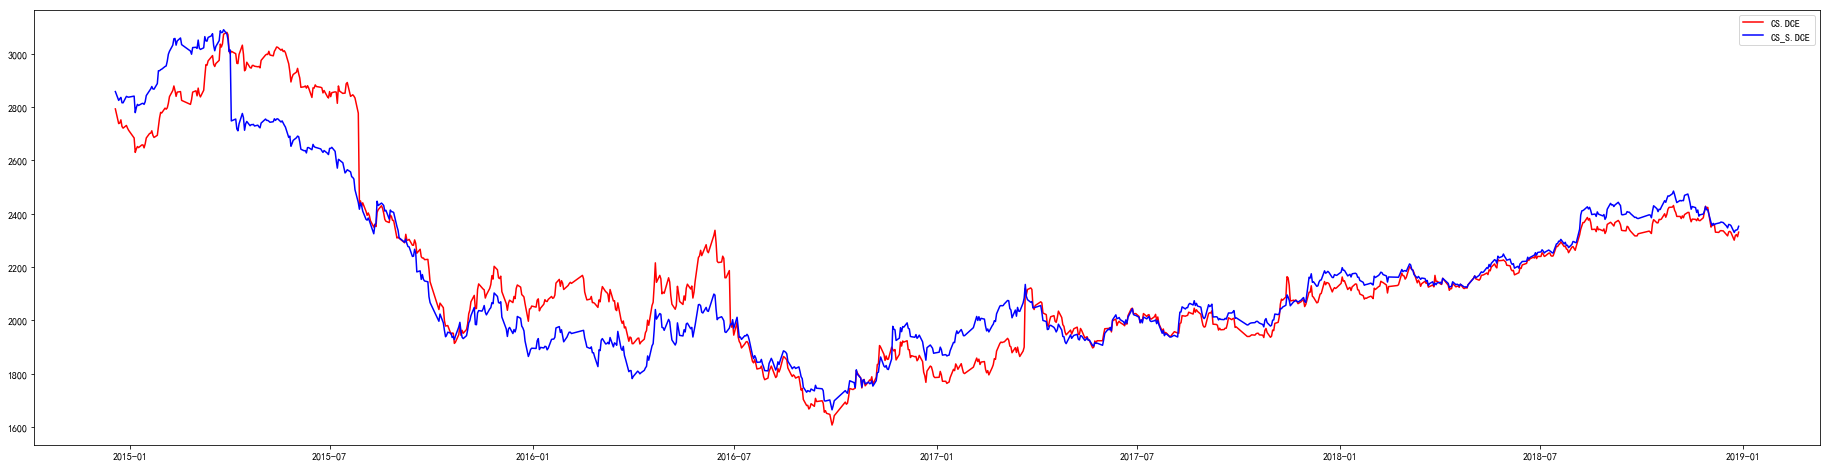

In [2]:
# 参数设置和数据准备
Exchange = "DCE"
MID, SID = "CS.DCE", "CS_S.DCE"# 主力合约, 次主力合约
StartDT = dt.datetime(2014, 12, 19)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
CCPrice = FT.readData(factor_names=[PriceFactor], ids=[MID, SID], dts=DTs).iloc[0]
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()
# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CCPrice.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
Axes.plot(CCPrice.index, CCPrice.values[:, 0], color='r', label=CCPrice.columns[0])
Axes.plot(CCPrice.index, CCPrice.values[:, 1], color='b', label=CCPrice.columns[1])
Axes.legend(loc='best');

# 附录

## 期货合约

![玉米淀粉期货合约](.\images\玉米淀粉期货合约.PNG)

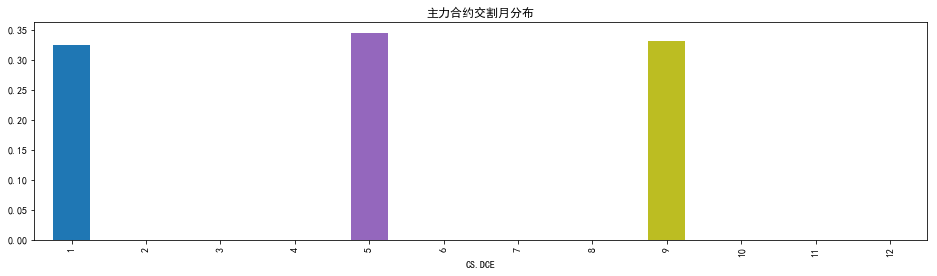

In [3]:
# 获取主力合约的月合约的交割月分布
import re
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
ExpiryMonthDistribution = ExpiryMonth.groupby(by=ExpiryMonth).count() / ExpiryMonth.shape[0]
ExpiryMonthDistribution = ExpiryMonthDistribution.loc[np.arange(1, 13)].fillna(0)
ExpiryMonthDistribution.plot(kind="bar", figsize=(16, 4), title="主力合约交割月分布");

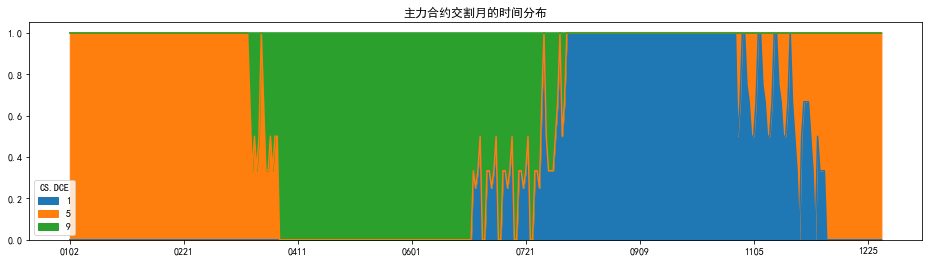

In [4]:
# 获取主力合约切换的时间分布
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
MonthDay = pd.Series([iDT.strftime("%m%d") for iDT in ExpiryMonth.index], index=ExpiryMonth.index)
ExpiryMonthDistributionPerYear = ExpiryMonth.groupby(by=[ExpiryMonth, MonthDay]).count().unstack()
ExpiryMonthDistributionPerYear = (ExpiryMonthDistributionPerYear / ExpiryMonth.groupby(by=MonthDay).count()).T
ExpiryMonthDistributionPerYear = ExpiryMonthDistributionPerYear.fillna(0)
Fig, Axes = plt.subplots(1, 1, figsize=(16, 4))
Axes = ExpiryMonthDistributionPerYear.plot(kind="area", ax=Axes, title="主力合约交割月的时间分布")
xTicks = Axes.get_xticks().astype(np.int)
xTickLabels = np.full(shape=xTicks.shape, fill_value="", dtype="O")
Mask = ((xTicks>=0) & (xTicks<ExpiryMonthDistributionPerYear.shape[0]))
xTickLabels[Mask] = ExpiryMonthDistributionPerYear.index.values[xTicks[Mask].tolist()]
Axes.set_xticklabels(xTickLabels);